In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,confusion_matrix

In [2]:
questions_data = pd.read_csv("questions_nb_predictions.csv")

In [3]:
questions_data.head(2)

,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Id,OwnerUserId,CreationDate,Score,Title,Body,highest_answer_score,num_answers,has_positive_answer,Full_Text,Title_Word_Count,Body_Word_Count,SPLIT,NB_prediction
0,0,0,0,0,469,147.0,2008-08-02T15:11:16Z,21,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...,12,4,1,How can I find the full path to a font from it...,17,70,TRAIN,0.400395
1,1,1,1,1,502,147.0,2008-08-02T17:01:58Z,27,Get a preview JPEG of a PDF on Windows?,<p>I have a cross-platform (Python) applicatio...,9,2,1,Get a preview JPEG of a PDF on Windows? <p>I h...,9,38,TRAIN,0.287295


In [4]:
from random import randint

In [5]:
questions_data['SPLIT'].value_counts()

TRAIN    441617
TEST     165665
Name: SPLIT, dtype: int64

In [6]:
train_split = questions_data.loc[questions_data['SPLIT'] == 'TRAIN']
test_split = questions_data.loc[questions_data['SPLIT'] == 'TEST']

In [7]:
X_train = train_split['Title']
X_test = test_split['Title']

y_train = train_split['has_positive_answer']
y_test = test_split['has_positive_answer']

In [8]:
vect = CountVectorizer(stop_words = 'english')

x_train_cv = vect.fit_transform(X_train)
x_test_cv = vect.transform(X_test)

In [9]:
clf = MultinomialNB()
clf.fit(x_train_cv, y_train)

MultinomialNB()

### Test on the holdout data

In [10]:
y_pred_raw = clf.predict_proba(x_test_cv)

In [11]:
# we want the probability of the 1 class
y_pred_raw = [x[1] for x in y_pred_raw]

In [12]:
y_pred = (np.array(y_pred_raw) > 0.5).astype(int)

In [13]:
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_raw)
auc = metrics.roc_auc_score(y_test, y_pred_raw)

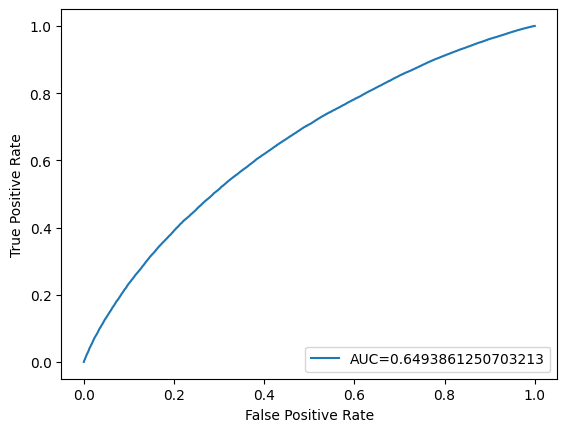

In [14]:
import matplotlib.pyplot as plt

plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [15]:
from sklearn.metrics import f1_score, precision_score, recall_score
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

In [16]:
from sklearn.metrics import f1_score, precision_score, recall_score
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

In [17]:
print(f"f1 score is: {f1}")
print(f"precision score is: {precision}")
print(f"recall score is: {recall}")

f1 score is: 0.7637812913396476
precision score is: 0.7205409758937187
recall score is: 0.8125427142908529


In [18]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)

<AxesSubplot:>

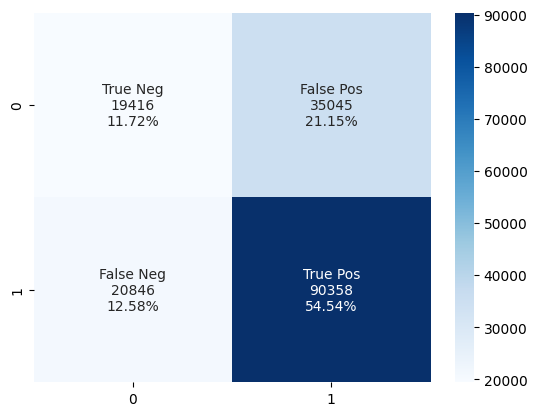

In [19]:
group_names = ["True Neg", "False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, fmt="", cmap='Blues', annot=labels)

## Use the predictions to add to the questions_data, and save it. This can be used later in combination with the pooled token

In [20]:
def make_prediction(title):
    transformed_title = vect.transform([title])
    pos_probability = clf.predict_proba(transformed_title)[0][1]
    return pos_probability

In [21]:
# questions_data['NB_prediction'] = questions_data.apply(lambda row: make_prediction(row['Title']), axis=1)

In [22]:
# questions_data.to_csv("questions_nb_predictions.csv")

In [23]:
# questions_data.head(5)

In [24]:
clf.feature_log_prob_

array([[-10.05660161, -10.55869355, -11.61474622, ..., -13.69418776,
        -13.00104058, -12.3078934 ],
       [ -9.70678346, -10.39007834, -12.24246243, ..., -13.62875679,
        -14.32190397, -12.71246606]])

In [25]:
len(vect.vocabulary_)

57671

In [26]:
result_probs = {}

for word in vect.vocabulary_:
    prob = make_prediction(word)
    result_probs[word] = prob

In [27]:
sorted_probs = sorted(result_probs.items(), key=lambda x: x[1], reverse=True)

In [41]:
probability_df = pd.DataFrame(sorted_probs)

In [42]:
probability_df.head(2)

,0,1
0,1s,0.969206
1,kinds,0.957967


In [43]:
probability_df['word'] = probability_df[0]

In [44]:
probability_df['posterior_probability'] = probability_df[1]

In [45]:
probability_df = probability_df.drop(0, axis=1).drop(1,axis=1)

In [69]:
probability_df.head(20)

,word,posterior_probability
0,1s,0.969206
1,kinds,0.957967
2,idiomatic,0.951303
3,hasattr,0.951303
4,isdir,0.951303
5,holds,0.951303
6,recommend,0.948586
7,puzzling,0.945548
8,ndim,0.945548
9,islice,0.945548


<AxesSubplot:ylabel='Frequency'>

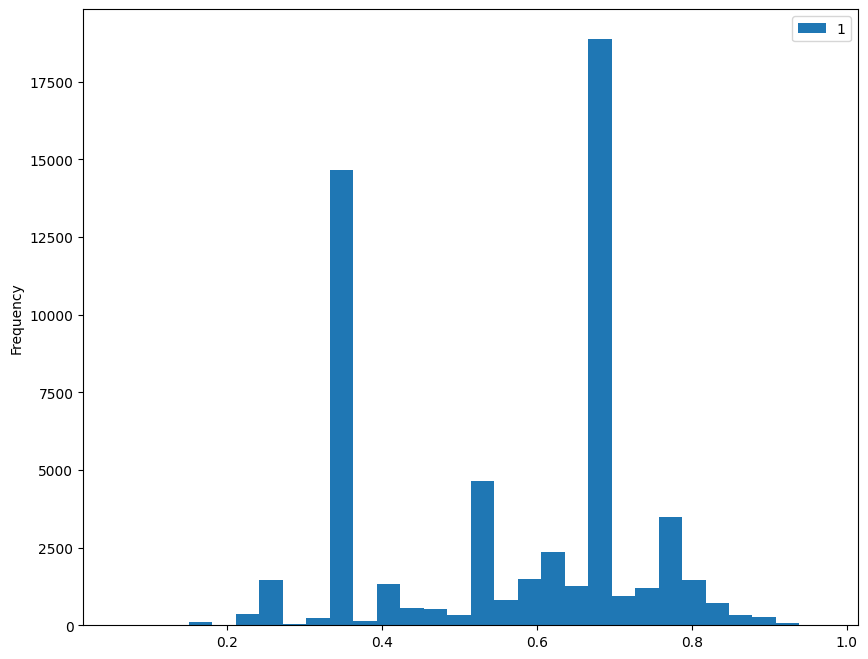

In [33]:
probability_df.plot.hist(column=[1], figsize=(10, 8), bins = 30)

In [47]:
probability_df.to_csv("word_posterior_probabilities.csv")

In [63]:
make_prediction("urgent uncaught exception")

0.638720663454077

In [71]:
make_prediction("asap")

0.6846004135850378